<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias_ngrams_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 2 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [3]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [4]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [41]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(28122, 3)


In [44]:
dfDados = dfDados.sample(frac=0.05)
print(dfDados.shape)

(1406, 3)


In [45]:
dfDados.columns

Index(['text', 'category', 'category_nro'], dtype='object')

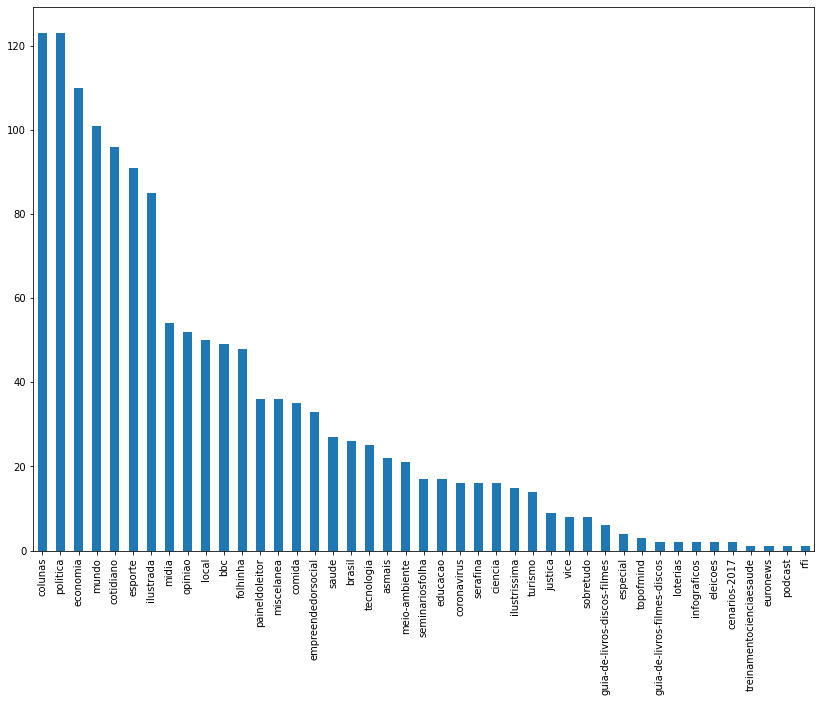

In [138]:
df = dfDados['category'].value_counts()
#df =df.head(40)
df.plot.bar(figsize=(14,10))


In [47]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 172 ms, sys: 98 ms, total: 270 ms
Wall time: 22.1 s


In [48]:
print(dfPreProc.shape)
dfPreProc.head()

(1406, 3)


text  ... category_nro
7712                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [49]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.9, ngrams=(1,3))
X_tfidf = retornaMatriztfIdf(V)

In [61]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
linkage_matrix = average(dist) #ward(dist)

CPU times: user 1.48 s, sys: 681 µs, total: 1.48 s
Wall time: 1.48 s


* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [ ]:
#X = np.ones((X_tfidf.shape))
#X_tfidf.toarray(out=X)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03433457, 0.01992446,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03860407,
        0.        ]])

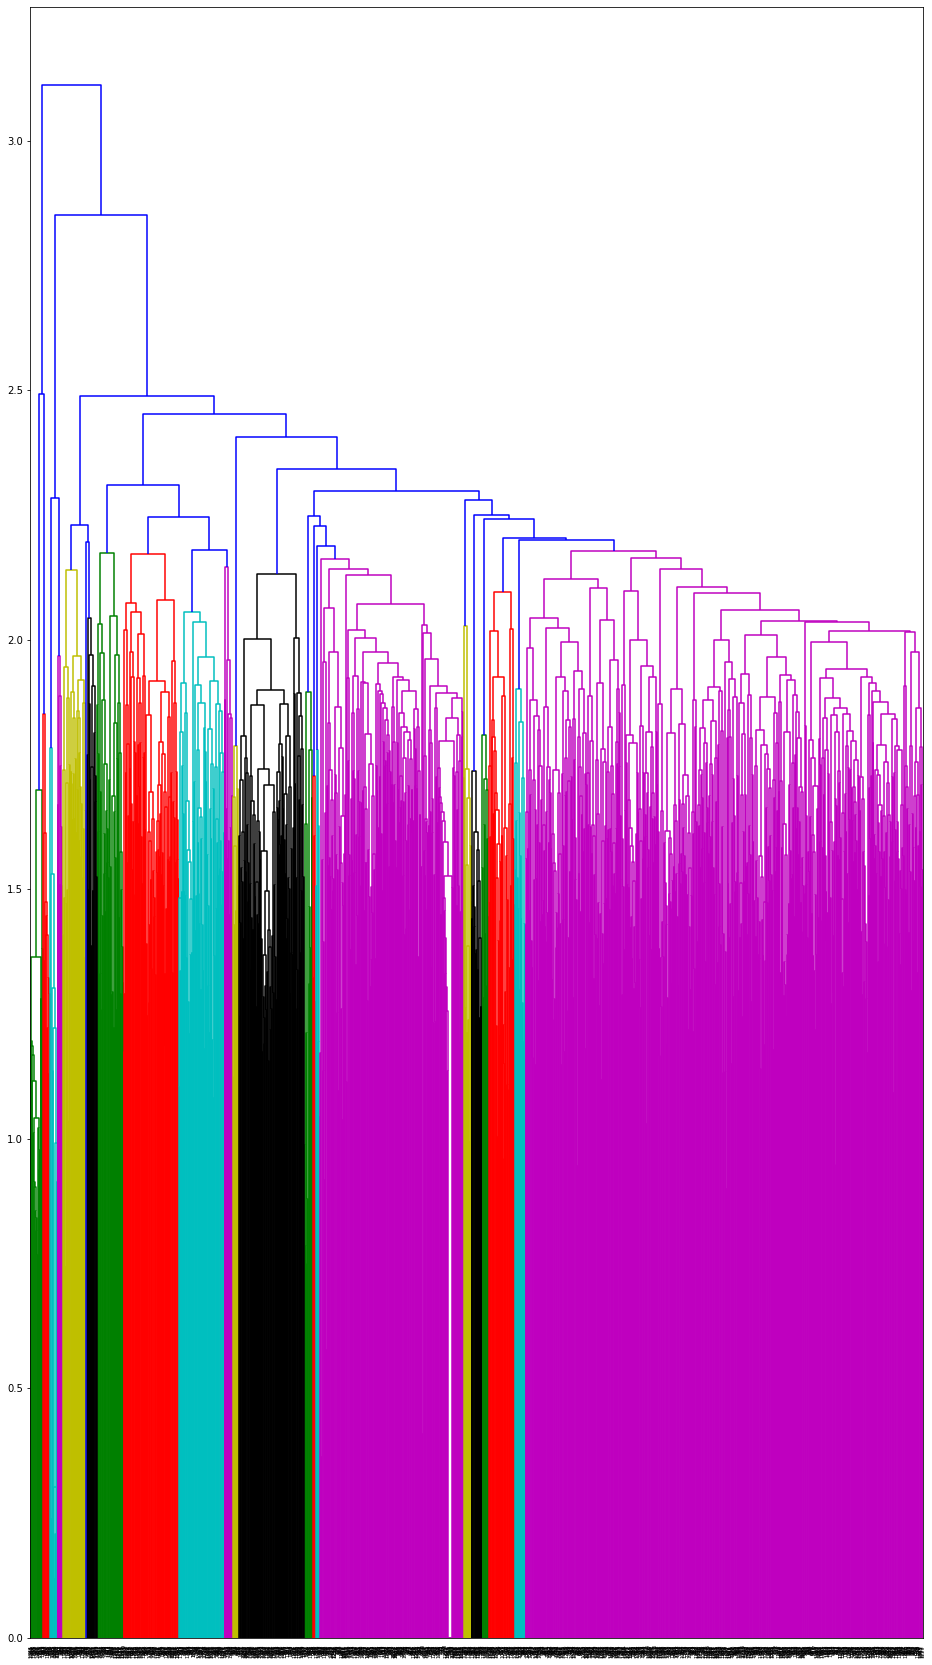

CPU times: user 30.8 s, sys: 2.52 s, total: 33.4 s
Wall time: 32.3 s


In [62]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

In [ ]:
def aplicaModelo(model, dfDados, X_tfidf):
  dfDadosPred = dfDados.copy()
  y_pred = model.fit_predict(X_tfidf.toarray())
  dfDadosPred['y_pred'] = y_pred
  print(dfDadosPred['y_pred'].value_counts())
  return dfDadosPred

Similaridade Coseno

In [65]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
model= AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='average')
y_pred = model.fit_predict(X_tfidf.toarray())

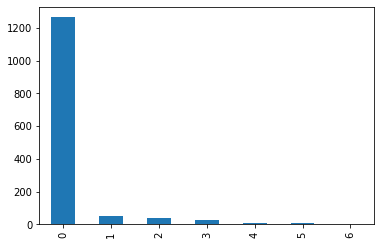

In [66]:
dfDados['y_pred'] = y_pred
dfconta = dfDados['y_pred'].value_counts().reset_index()
dfconta['y_pred'].plot.bar()

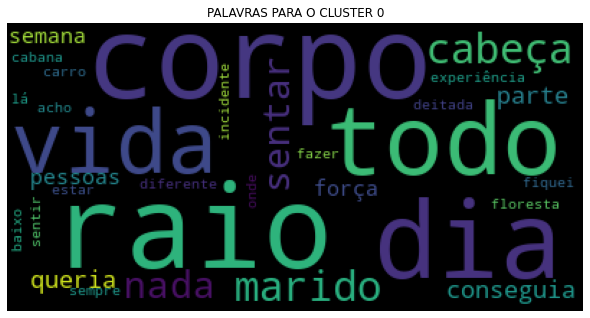

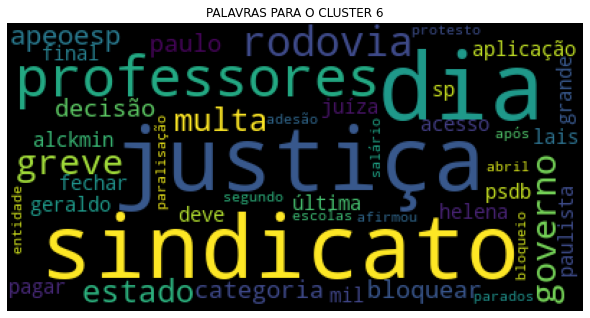

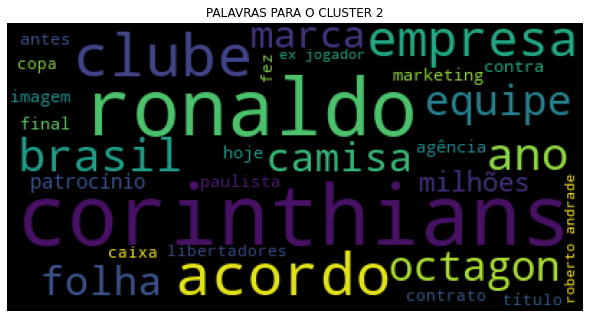

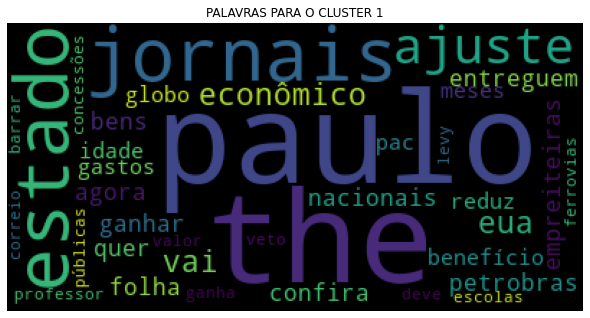

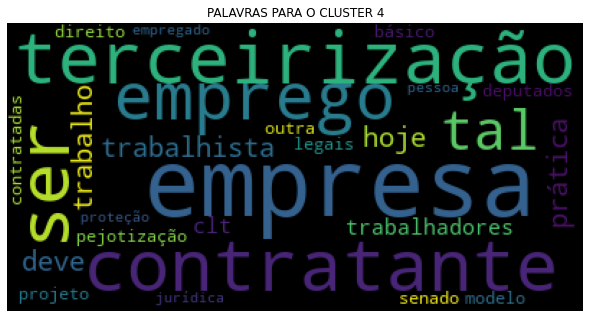

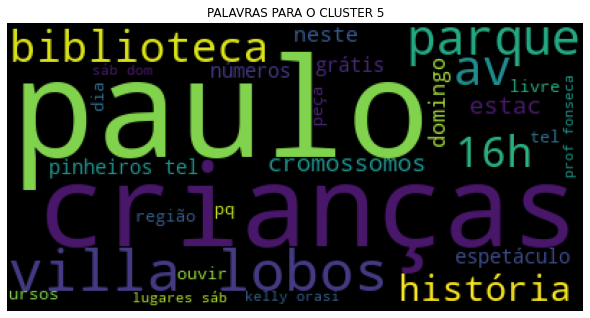

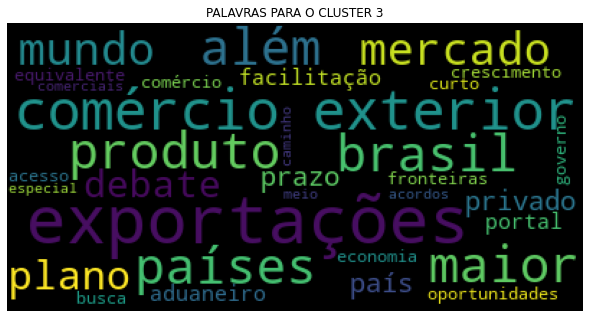

In [67]:
sw = nltk.corpus.stopwords.words('portuguese')
#for y in np.sort(dfDadosPred['y_pred'].unique()):
for y in dfconta['index'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y),sw)

## Euclidiana

Com 7 grupos

In [123]:
model= AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
y_pred = model.fit_predict(X_tfidf.toarray())

<BarContainer object of 7 artists>

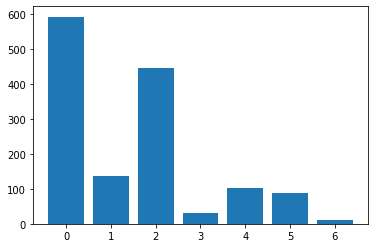

In [124]:
dfDados['y_pred_eucl'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred_eucl','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred_eucl','qtd',data=dfconta)


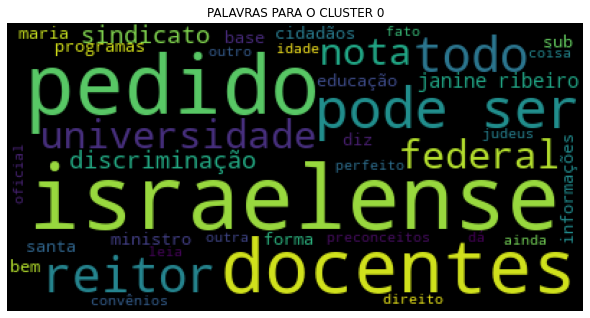

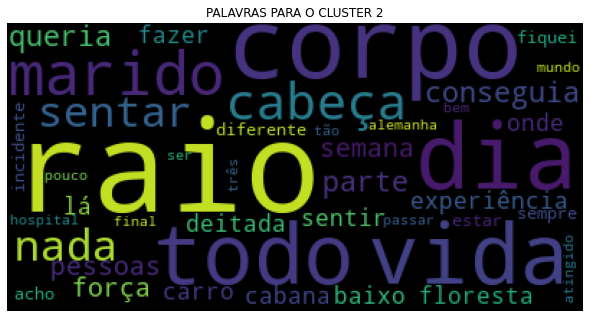

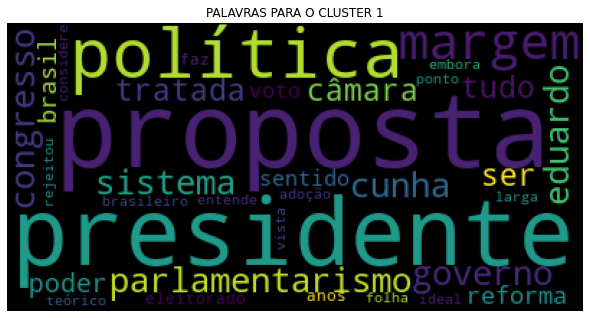

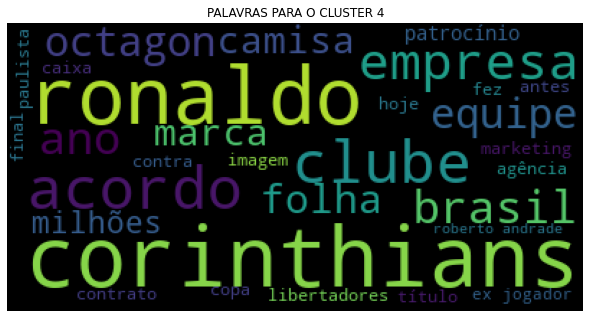

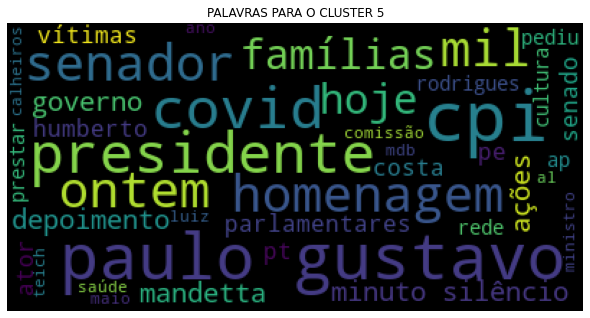

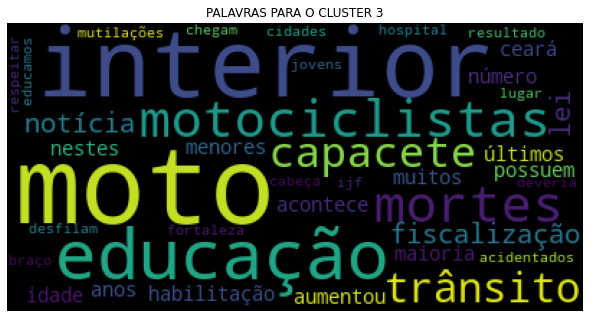

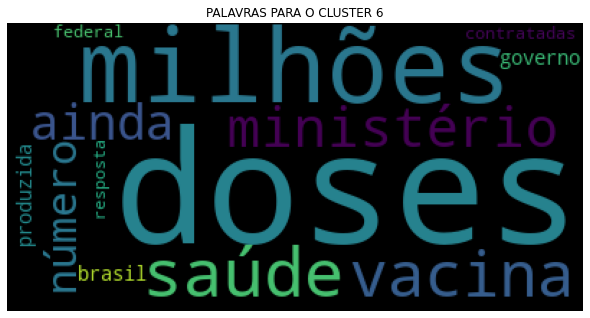

In [125]:
dfconta = dfDados['y_pred_eucl'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['index'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred_eucl']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

Com 11 grupos

In [132]:
model= AgglomerativeClustering(n_clusters=11, affinity='euclidean', linkage='ward')
y_pred = model.fit_predict(X_tfidf.toarray())

<BarContainer object of 11 artists>

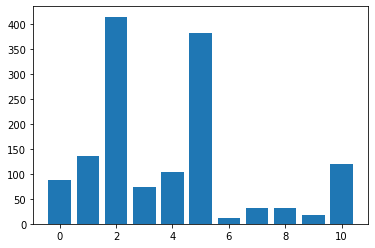

In [133]:
dfDados['y_pred_eucl'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred_eucl','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred_eucl','qtd',data=dfconta)

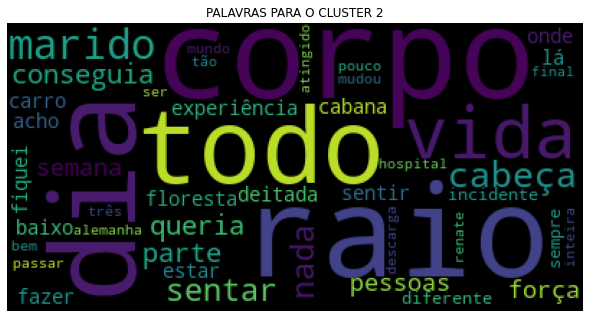

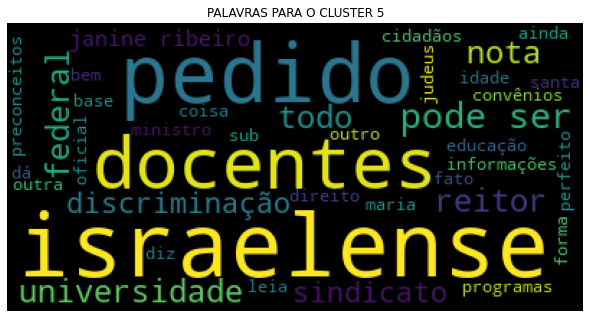

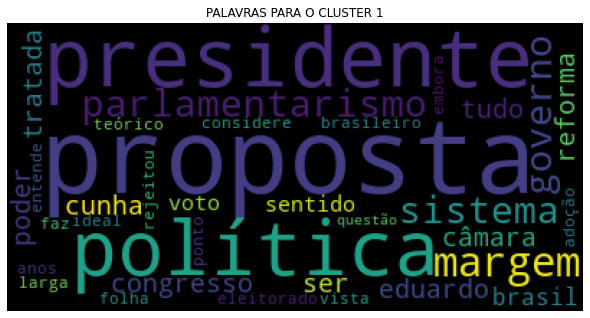

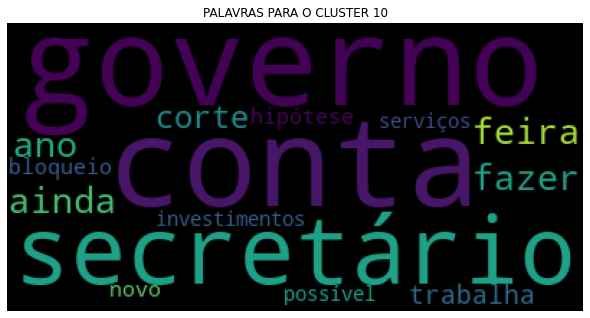

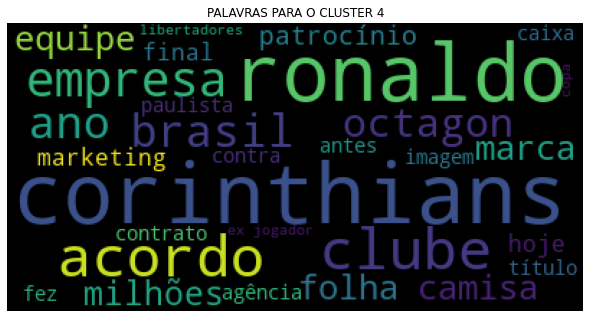

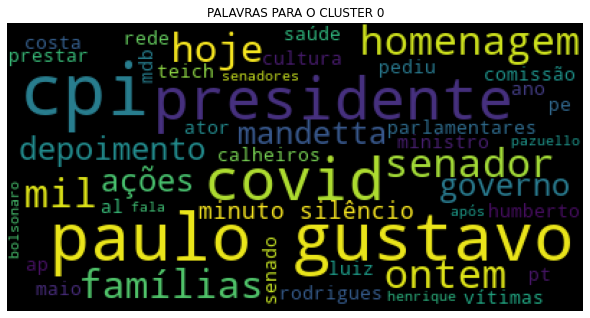

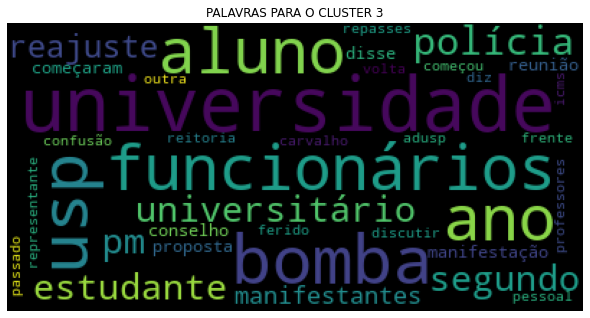

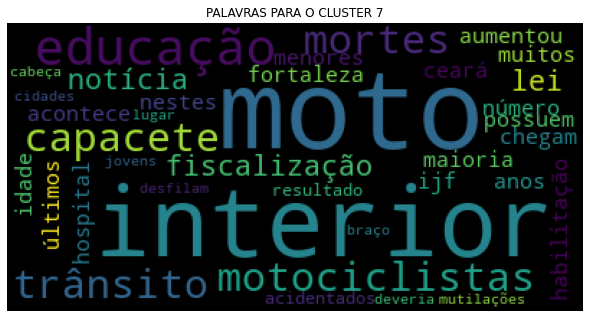

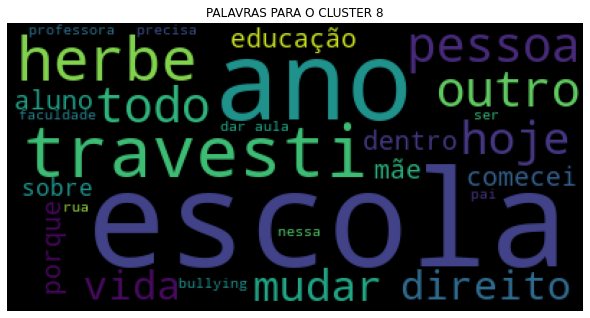

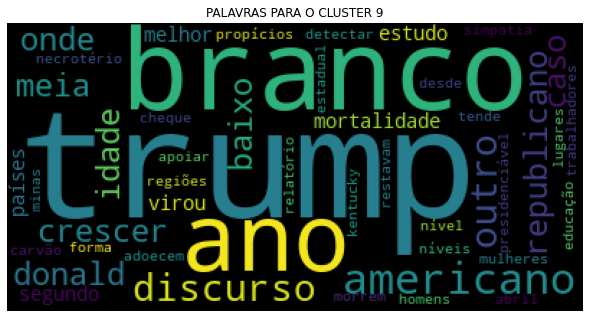

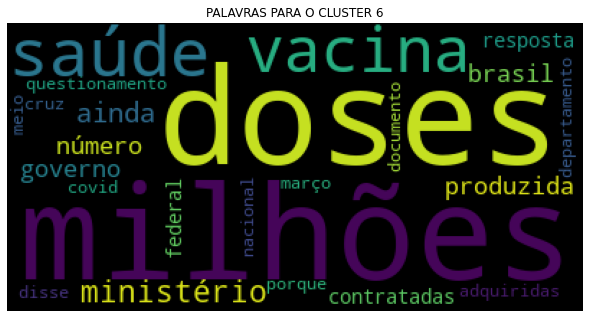

In [128]:
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred_eucl'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred_eucl']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

Com 19 grupos

In [129]:
model= AgglomerativeClustering(n_clusters=19, affinity='euclidean', linkage='ward')
y_pred = model.fit_predict(X_tfidf.toarray())

<BarContainer object of 19 artists>

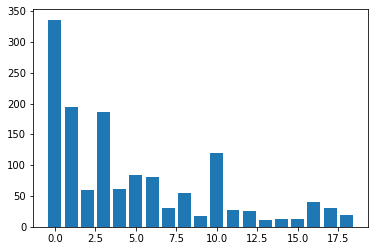

In [130]:
dfDados['y_pred_eucl'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred_eucl','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred_eucl','qtd',data=dfconta)


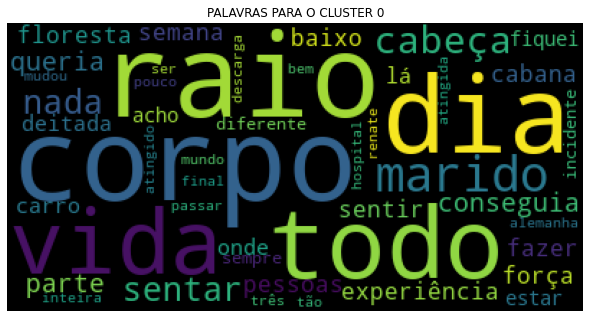

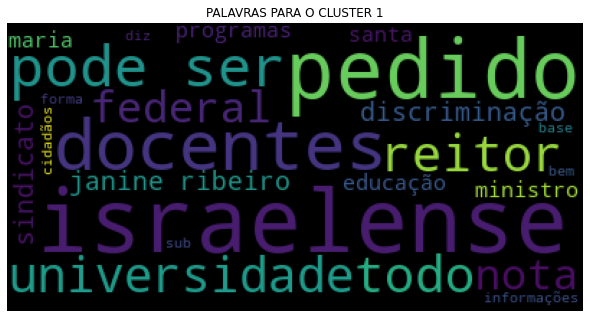

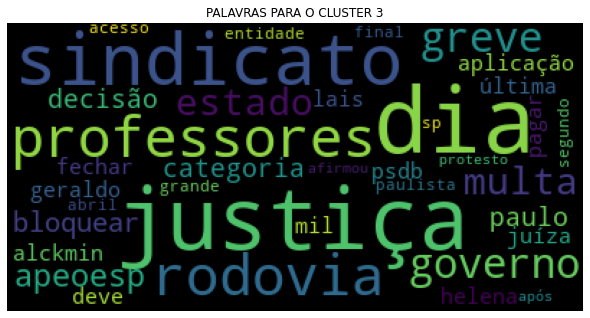

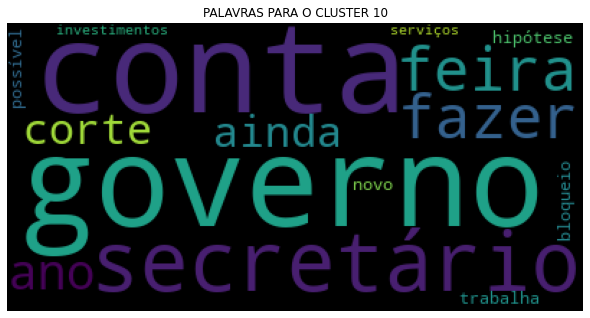

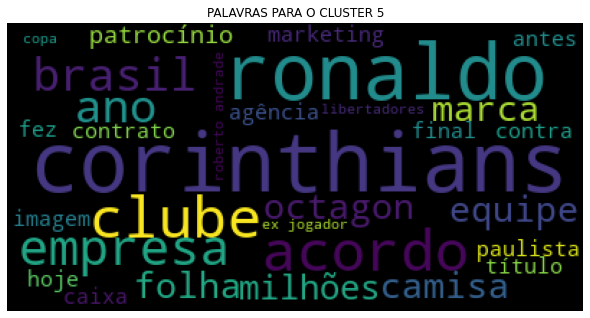

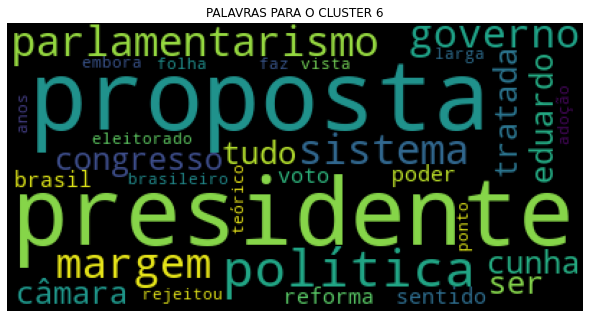

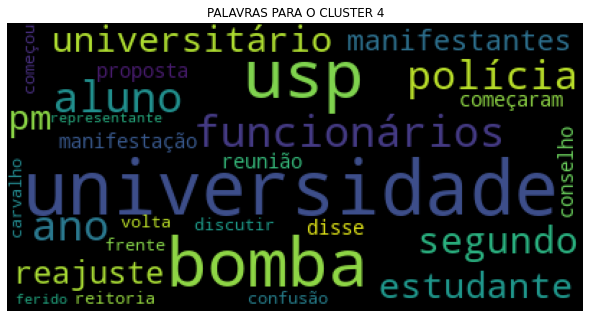

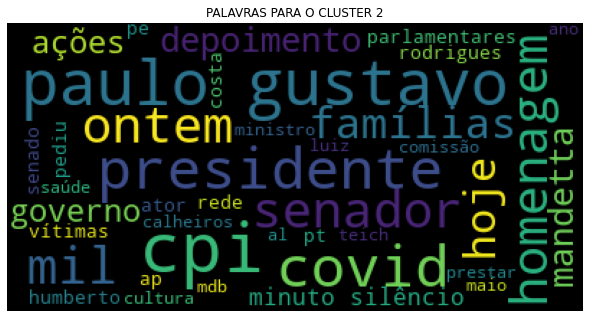

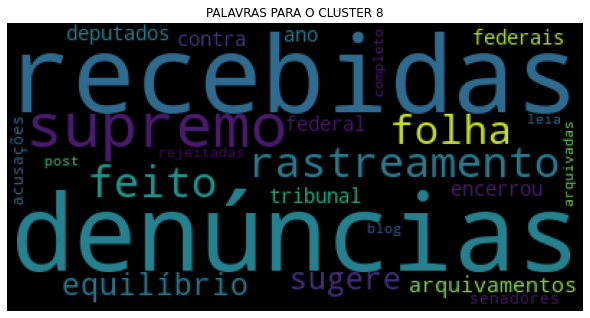

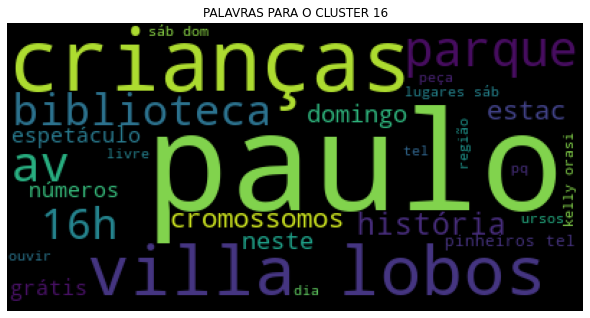

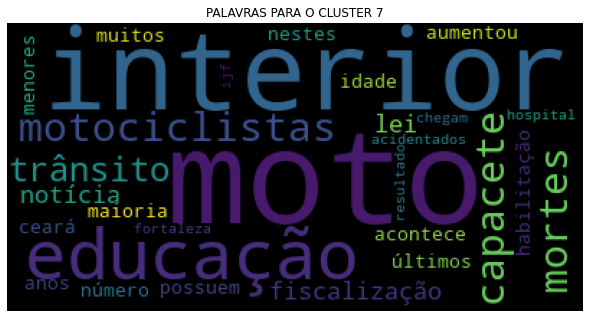

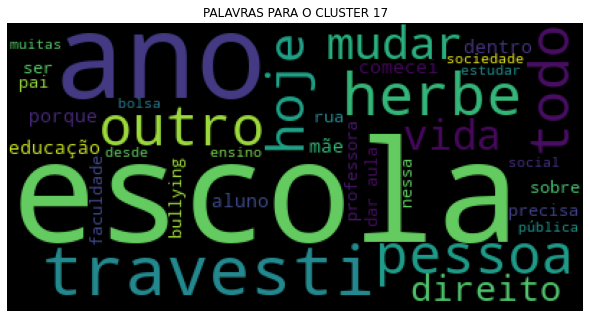

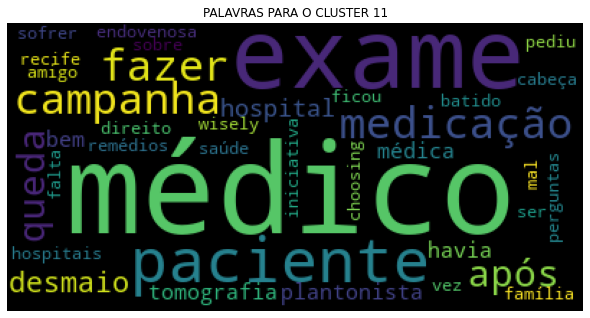

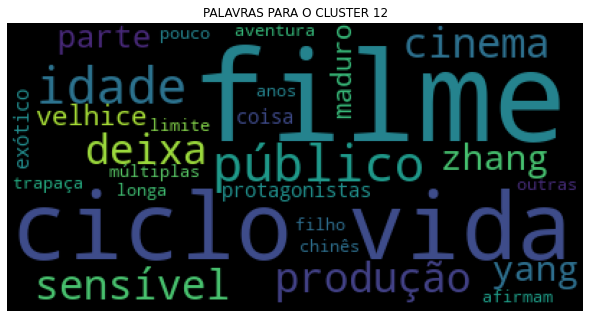

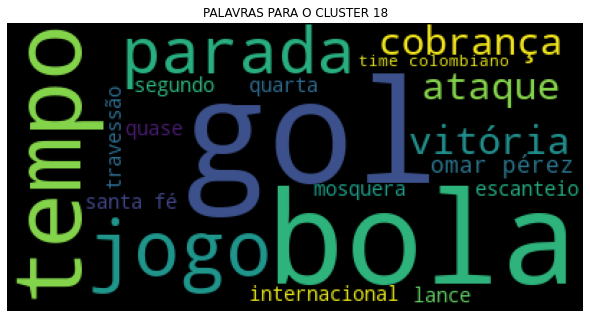

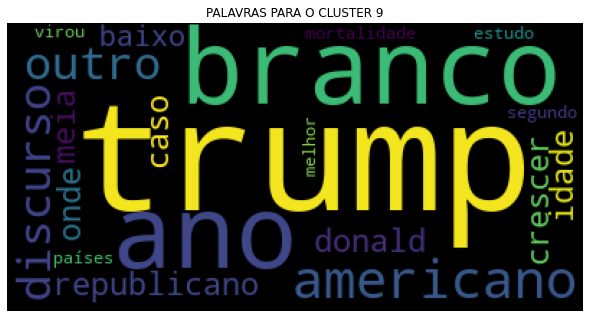

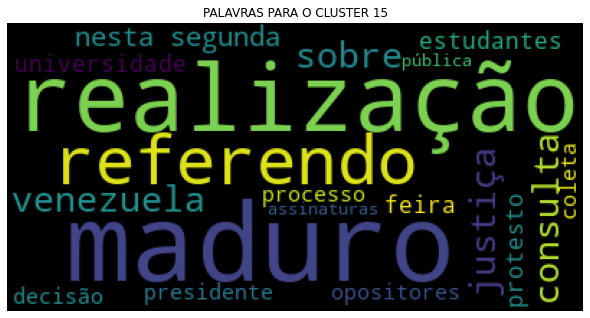

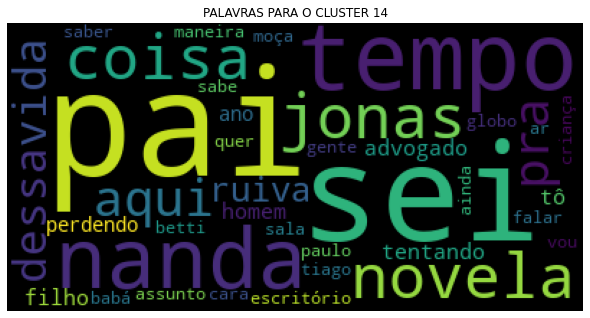

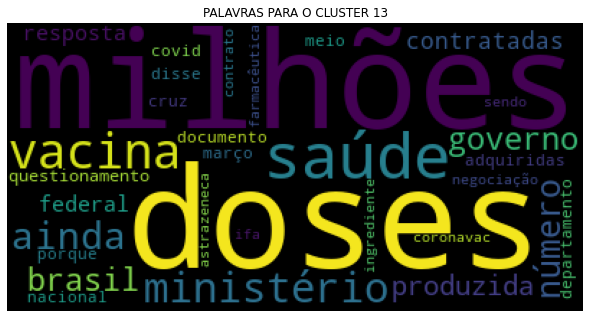

In [131]:
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['y_pred_eucl'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred_eucl']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

In [137]:
dfDados[dfDados['y_pred_eucl']==2][['category','y_pred_eucl']].groupby('category').count().reset_index().rename(columns={'y_pred_eucl':'qtd'}).sort_values(by='qtd', ascending=False)

category  qtd
15                     ilustrada   77
12                      folhinha   41
4                        colunas   36
18                         local   35
21                         midia   34
5                         comida   29
6                      cotidiano   23
30                      serafina   15
27                      politica   12
1                            bbc   12
11                       esporte   10
9             empreendedorsocial    9
22                    miscelanea    9
16                  ilustrissima    8
7                       economia    8
32                    tecnologia    6
35                          vice    6
13  guia-de-livros-discos-filmes    6
28                         saude    5
23                         mundo    4
10                      especial    3
31                     sobretudo    3
0                         asmais    2
2                         brasil    2
19                      loterias    2
20                 meio-ambiente    2
34                       turismo    2
14  guia-de-livros-filmes-discos    2
8                       educacao    2
29               seminariosfolha    2
3                        ciencia    2
33      treinamentocienciaesaude    1
17                  infograficos    1
25                paineldoleitor    1
24                       opiniao    1
26                       podcast    1

In [83]:
dfDados[dfDados['y_pred_eucl']==0].sample(10)

text  ... y_pred_eucl
11647                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          "Deus vai dar a eles o que merecem", disse na tarde desta sexta-feira (10) a mãe de uma das vítimas de um estupro coletivo que resultou na condenação de quatro adolescentes pelo crime.  Os rapazes –na faixa etária de 15 a 17 anos– foram condenados a três anos de detenção por participação no estupro coletivo contra quatro garotas no município de Castelo do Piauí (a 190 km de Teresina).  Para a mãe de uma das vítimas, que não quis se identificar, a pena dada pela Justiça é pequena diante da barbaridade cometida pelos adolescentes.  "Mas a Justiça é quem sabe. Fico pensando quando esses meninos saírem e voltarem para Castelo. Entrego o destino deles a Deus. Sou contra mandar fazer vingança", disse à Folha.    Em acompanhamento psicológico e não tem acesso à internet, a filha dela não sabe que uma das vítimas morreu. As quatro meninas estupradas em 27 de maio foram amarradas, violentadas sexualmente a jogadas de um morro de cerca de 10 metros nos arredores do município.  Elas faziam fotos para tarefas escolares quando foram atacadas. Danielly Rodrigues Feitosa, a garota que morreu, tinha 17 anos. Ela teve esmagamento da face e fraturas no pescoço e tórax. As outras três foram internadas com traumatismo craniano, fratura no punho e tornozelo, mas já tiveram alta hospitalar.  No estupro coletivo, participaram os quatro adolescentes e um suspeito adulto –Adão José da Silva, 40. O promotor pediu a condenação de mais de 160 anos de prisão para ele, que é citado como líder do estupro. O juiz ainda não deu a sentença do Adão José da Silva, pois seu processo é separado dos menores.  Na decisão, o juiz Leonardo Brasileiro decretou a internação dos menores no CEM (Centro Educacional Masculino), em Teresina, pelos crimes de estupro coletivo, homicídio e tentativa de homicídio.  Na sentença, o magistrado solicita que os adolescentes sejam submetidos a avaliações comportamentais a cada seis meses e o relatório será encaminhado à Justiça. O juiz solicitou também que os quatro menores irão receber tratamento médico, já que são usuários de droga.  'LOIRINHA BOA'  "A intenção deles era matar as adolescentes. Foi um crime com requinte de crueldade, sem possibilidade de defesa das vítimas, com ato de desprezo, chacota, ironia –chegaram a chamar vítima de 'loirinha boa'– e por motivo torpe", disse o promotor Cezário de Souza Cavalcante Neto, que acompanhou o caso.  Segundo ele, a sentença do juiz foi bem fundamentada, mas o promotor poderá contestar os itens em que o magistrado não considerou os crimes de corrupção de menores e associação criminal.  ...           0
10621                                                                                                                                                                                                                                                                                                                                                                                                                                          